# Reinforcement Learning
Prof. Milica Gašić

### TD control

In this notebook we will implement the three TD control algorithms SARSA, Q-learning and expected SARSA.  
The main difference between them is the TD target, e.g. for SARSA:

$\begin{equation}
    Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha (\,\underbrace{r_{t+1} + \gamma Q(s_{t+1}, a_{t+1})}_{\text{TD target}} - Q(s_t, a_t))
\end{equation}$

The targets of Q-learning and expected SARSA can be found in the slides.  
Another difference is whether the next action is already selected before the update (only SARSA).

#### Implementation

Make sure that the files `rl_agent.py` and `rl_env.py` are in the same folder as the notebook.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import rl_agent
import rl_env

#### Agents

The class `TDAgent` is a base class and uses the method `compute_target()` to compute the TD target.  
The three TD agents are subclasses of `TDAgent` and only need to implement this method.  
Follow the instructions in the code cells below.

In [2]:
class TDAgent(rl_agent.TabularAgent):

    def __init__(self, env, gamma, epsilon, alpha, rng=None):
        super().__init__(env)
        self.gamma = gamma  # discount factor
        self.epsilon = epsilon  # epsilon-greedy probability
        self.alpha = alpha  # learning rate
        self.rng = rng if rng is not None else np.random.default_rng()
        self.reset()

    def reset(self):
        # Create array for action values
        self.q = np.zeros((self.num_states, self.num_actions), dtype=float)
        # Create array for policy distribution (initialized uniformly)
        self.pi = np.full((self.num_states, self.num_actions), 1 / self.num_actions)

    def policy(self, state):
        # Sample an action according to pi
        action_probs = self.pi[state]
        action = self.rng.choice(self.num_actions, p=action_probs)
        return action

    def value(self, state):
        # Compute the state value from q and pi
        return np.sum(self.pi[state] * self.q[state])

    def action_value(self, state, action):
        # Lookup the action value in q
        return self.q[state, action]

    def policy_evaluation(self, state, action, reward, next_state, terminated, truncated):
        #######################################################################
        # TODO reuse, i.e. paste, policy evaluation code from last week       #
        #######################################################################

        next_action, target = \
            (None, reward) if terminated else self.compute_target(reward, next_state)

        self.q[state, action] += self.alpha * (target - self.q[state, action])

        return next_action

        #######################################################################
        # End of your code.                                                   #
        #######################################################################

    def compute_target(self, reward, next_state):
        # Compute the TD target and the next action, if necessary.
        # Needs to be implemented in a subclass.
        raise NotImplementedError()

    def policy_improvement(self):
        # Update the policy using epsilon-greedy policy improvement
        q = self.q
        epsilon = self.epsilon

        # Find the maximizing actions
        max_q = np.max(q, axis=1, keepdims=True)
        max_mask = q == max_q
        num_max = np.sum(max_mask, axis=1, keepdims=True)

        # Compute the probabilities
        num_actions = q.shape[1]
        pi = ((1 - epsilon) / num_max) * max_mask
        pi += epsilon / num_actions
        self.pi = pi

In [3]:
class SarsaAgent(TDAgent):

    def compute_target(self, reward, next_state):
        #######################################################################
        # TODO reuse, i.e. paste, sarsa target code from last week            #
        #######################################################################

        next_action = self.policy(next_state)
        target = reward + self.gamma * self.q[next_state, next_action]

        return next_action, target

        #######################################################################
        # End of your code.                                                   #
        #######################################################################

In [4]:
class QLearningAgent(TDAgent):

    def compute_target(self, reward, next_state):
        #######################################################################
        # TODO reuse, i.e. paste, Q Learning target code from last week       #
        #######################################################################

        target = reward + self.gamma * np.max(self.q[next_state])

        return None, target

        #######################################################################
        # End of your code.                                                   #
        #######################################################################

In [5]:
class ExpectedSarsaAgent(TDAgent):

    def compute_target(self, reward, next_state):
        #######################################################################
        # TODO NEW Calculate the expected SARSA target.                       #
        #######################################################################

        target = reward + self.gamma * np.sum(self.pi[next_state] * self.q[next_state, :])

        return None, target

        #######################################################################
        # End of your code.                                                   #
        #######################################################################

#### Evaluation

Now we evaluate the three TD agents on the cliff walking environment.  
The goal is to recreate Figure 6.3 from the textbook http://incompleteideas.net/book/the-book-2nd.html  
which compares different learning rates $\alpha$.

First implement `train_td_agent()`, which learns a policy.

In [6]:
def train_td_agent(env, agent, num_episodes):
    #######################################################################
    # TODO reuse, i.e. paste, training loop code from last week           #
    #######################################################################

    for _ in tqdm(range(num_episodes), desc='Episode', leave=False):
        state, _ = env.reset()
        next_action = None
        terminated = False

        while not terminated:
            action = agent.policy(state) if next_action is None else next_action
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_action = agent.policy_evaluation(state, action, reward,
                                                  next_state, terminated, truncated)
            agent.policy_improvement()
            state = next_state

    #######################################################################
    # End of your code.                                                   #
    #######################################################################

Now implement `evaluate_td_agent()`, which evaluates a learned policy.

In [7]:
def evaluate_td_agent(env, agent, num_episodes):
    #######################################################################
    # TODO reuse, i.e. paste, evaluation loop code from last week         #
    #######################################################################

    R = 0.0
    for _ in range(num_episodes):
        state, _ = env.reset()
        terminated = False

        while not terminated:
            action = agent.policy(state)
            state, reward, terminated, *_ = env.step(action)
            R += reward

    return R / num_episodes

    #######################################################################
    # End of your code.                                                   #
    #######################################################################

Now we evaluate the three TD agents in the cliff walking environment.  
We want to compare their results when using different learning rates $\alpha \in \{0.1, 0.4, 0.7, 1.0\}$,  
so you need to train and evaluate each agent four times.  
Always use $\gamma = 1.0$ and $\epsilon = 0.1$, and train and evaluate for $3000$ episodes.

Agent:   0%|          | 0/3 [00:00<?, ?it/s]

Alpha:   0%|          | 0/18 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Alpha:   0%|          | 0/18 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Alpha:   0%|          | 0/18 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

Episode:   0%|          | 0/3000 [00:00<?, ?it/s]

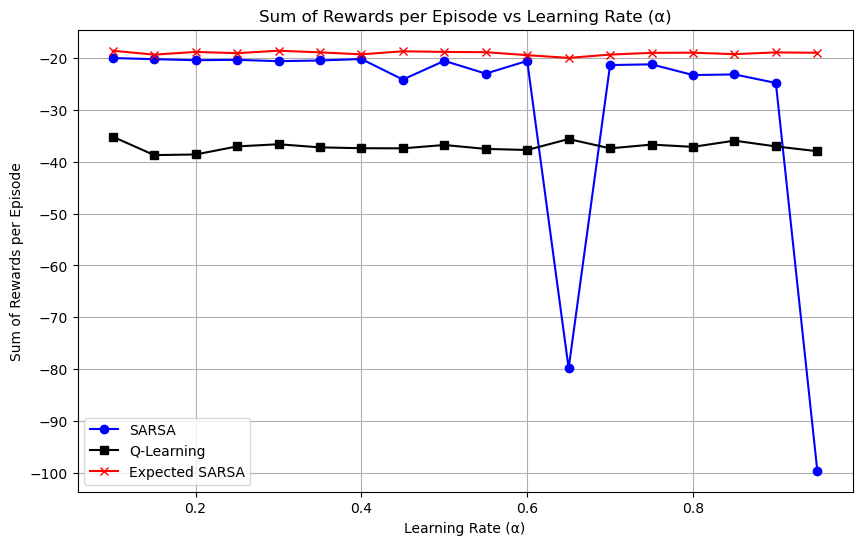

In [8]:
# Create a cliff walking environment
env = rl_env.cliff_walking()
gamma = 1.0  # discount factor
epsilon = 0.1  # epsilon-greedy probability
alphas = np.arange(0.1, 1, 0.05)  # learning rates
num_train_episodes = 3000  # number of episodes for training
num_eval_episodes = 3000  # number of episodes for evaluation


#######################################################################
# TODO Train and evaluate the three agents as described above. Plot   #
# the resulting sums of rewards per episode, to recreate Figure 6.3   #
# from the textbook. Reuse code from last week and add an             #
# expected sarsa agent for each alpha                                 #
#######################################################################

def R_per_alpha(agent_init):
    for alpha in tqdm(alphas, desc='Alpha', leave=False):
        agent = agent_init(env, gamma, epsilon, alpha)
        train_td_agent(env, agent, num_train_episodes)
        yield evaluate_td_agent(env, agent, num_eval_episodes)


agents = [(SarsaAgent, 'SARSA', 'o', 'blue'),
          (QLearningAgent, 'Q-Learning', 's', 'black'),
          (ExpectedSarsaAgent, 'Expected SARSA', 'x', 'red')]

plt.figure(figsize=(10, 6))

data = tqdm(agents, desc='Agent')

for agent, label, marker, color in data:
    R = list(R_per_alpha(agent))
    plt.plot(alphas, R, label=label, marker=marker, color=color)

# Customize the plot
plt.title('Sum of Rewards per Episode vs Learning Rate (α)')
plt.xlabel('Learning Rate (α)')
plt.ylabel('Sum of Rewards per Episode')
plt.legend()
plt.grid()
plt.show()

#######################################################################
# End of your code.                                                   #
#######################################################################

What do you observe?